### Task

The goal of this task is to implement the **calculation of the shortest distance between rectangles** on a given source image.

![Example Patterns](images/patterns_lengths_example.jpg)

To keep things simple, we will implement the solution only on a basic static image with several rectangles. The **source image for the basic version is** [patterns_photo_basic.jpg](patterns_photo_basic.jpg). We are interested in the **shortest distances in centimeters**, not pixels.

![Source Image](images/patterns_thumb.jpg)

### Import of libraries

In [ ]:
import cv2
import numpy as np
import math

from improutils import *

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/venv/lib/python3.7/site-packages/qrdet/qrdet.py:125: UserWarning: QRDetector has been updated to use the new YoloV8 model. Use legacy=True when calling detect for backwards compatibility with 1.x versions. Or update to new output (new output is a tuple of dicts, containing several new information (1.x output is accessible through 'bbox_xyxy' and 'confidence').Forget this message if you are reading it from QReader. [This is a first download warning and will be removed at 2.1]
  warn("QRDetector has been updated to use the new YoloV8 model. Use legacy=True when calling detect "


### Segmentation basics

Load and display an image.

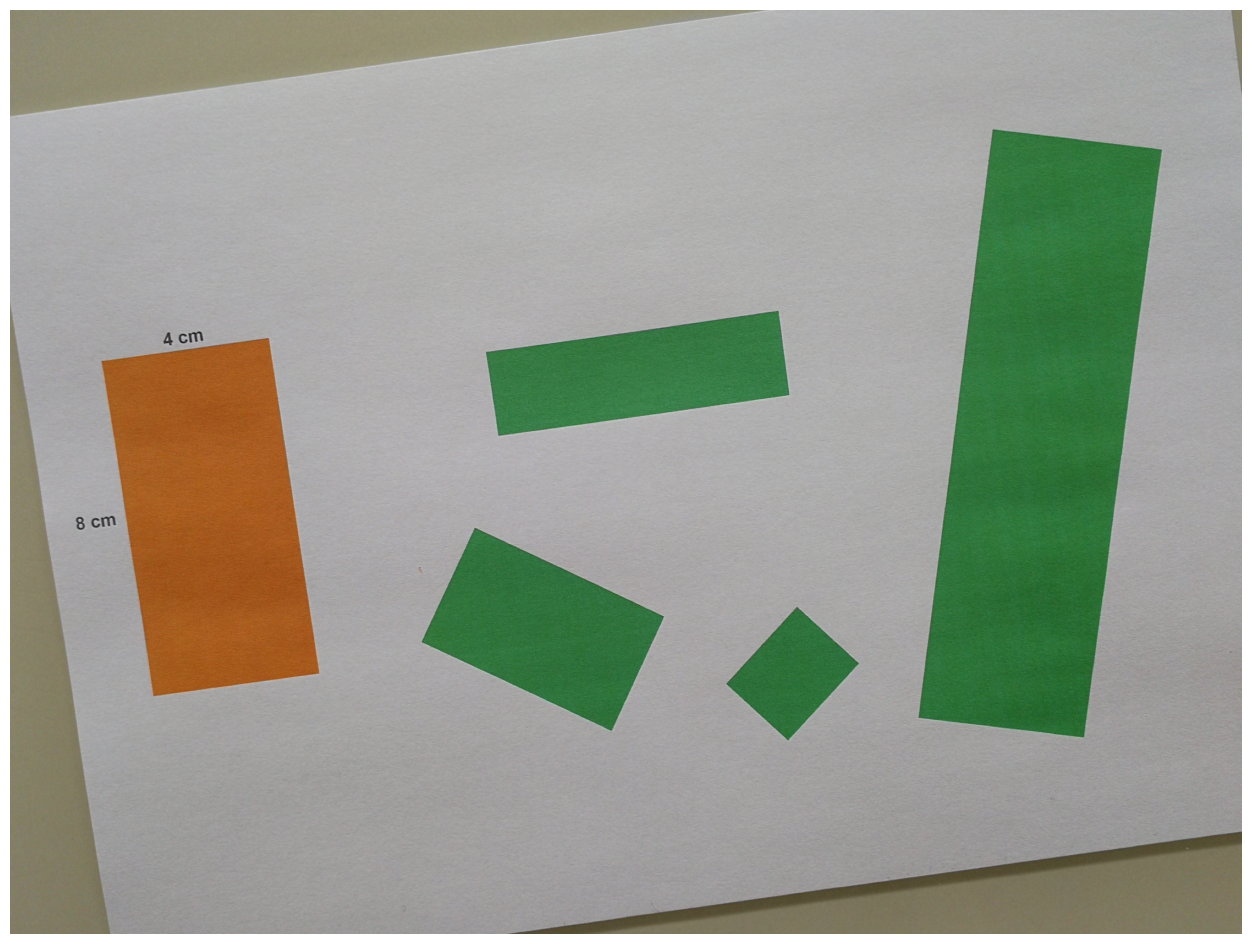

In [ ]:
img = load_image("patterns_photo_basic.jpg")
plot_images(img)

Preprocess and filter an image, performing rotation, cropping and median filtration.

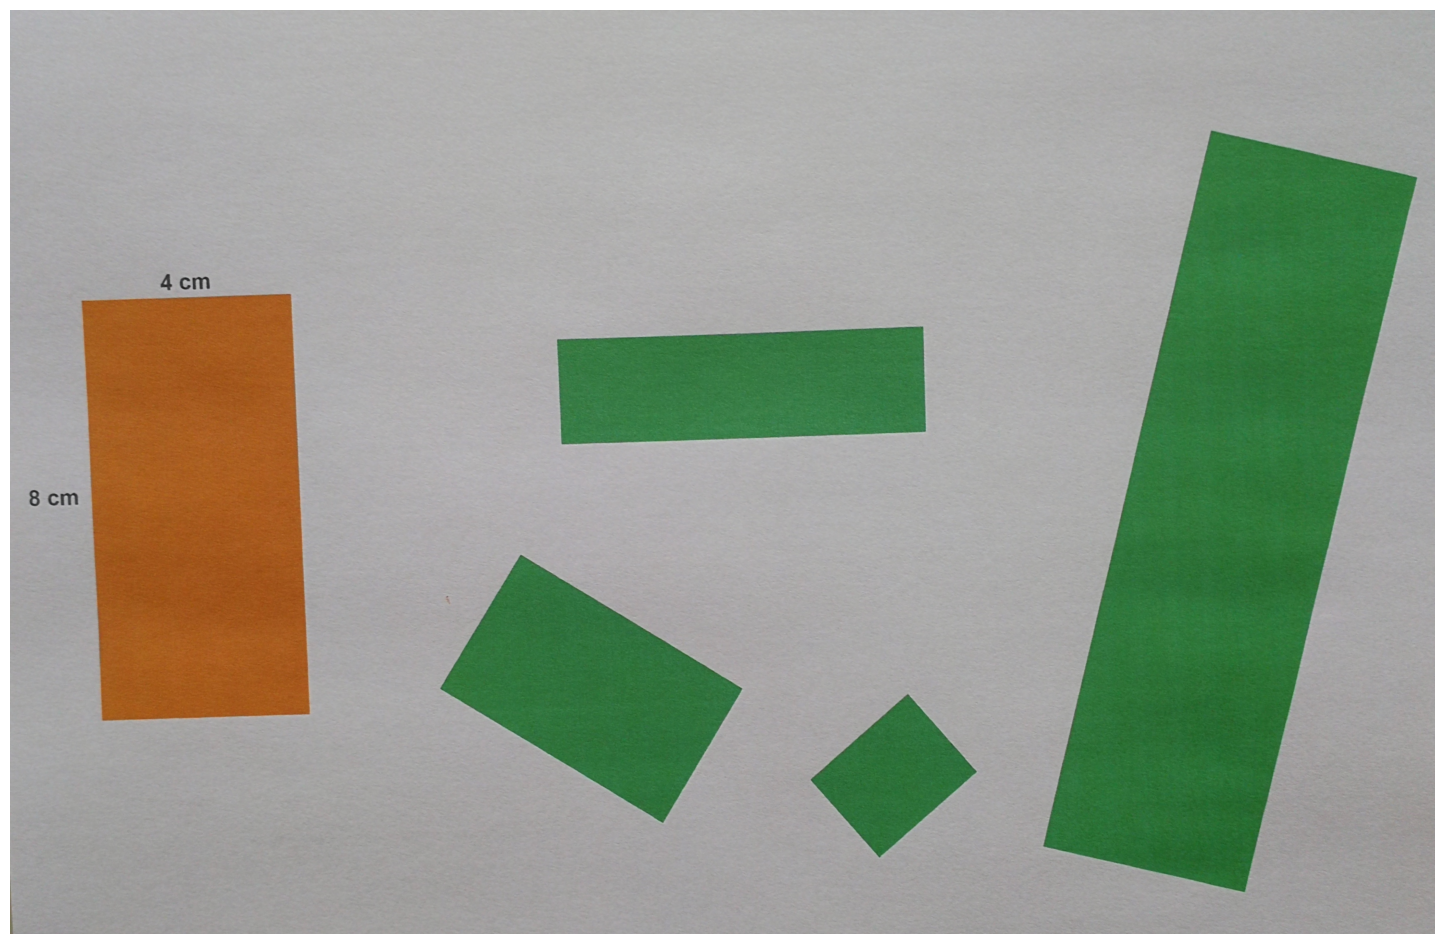

In [ ]:
img = rotate(img, -6)
img = crop(img, 300, 400, 4000, 2800)
img = filtration_median(img, 3)
plot_images(img)

Rectangles segmentation (orange and green rectangles separetely) and contour detection.

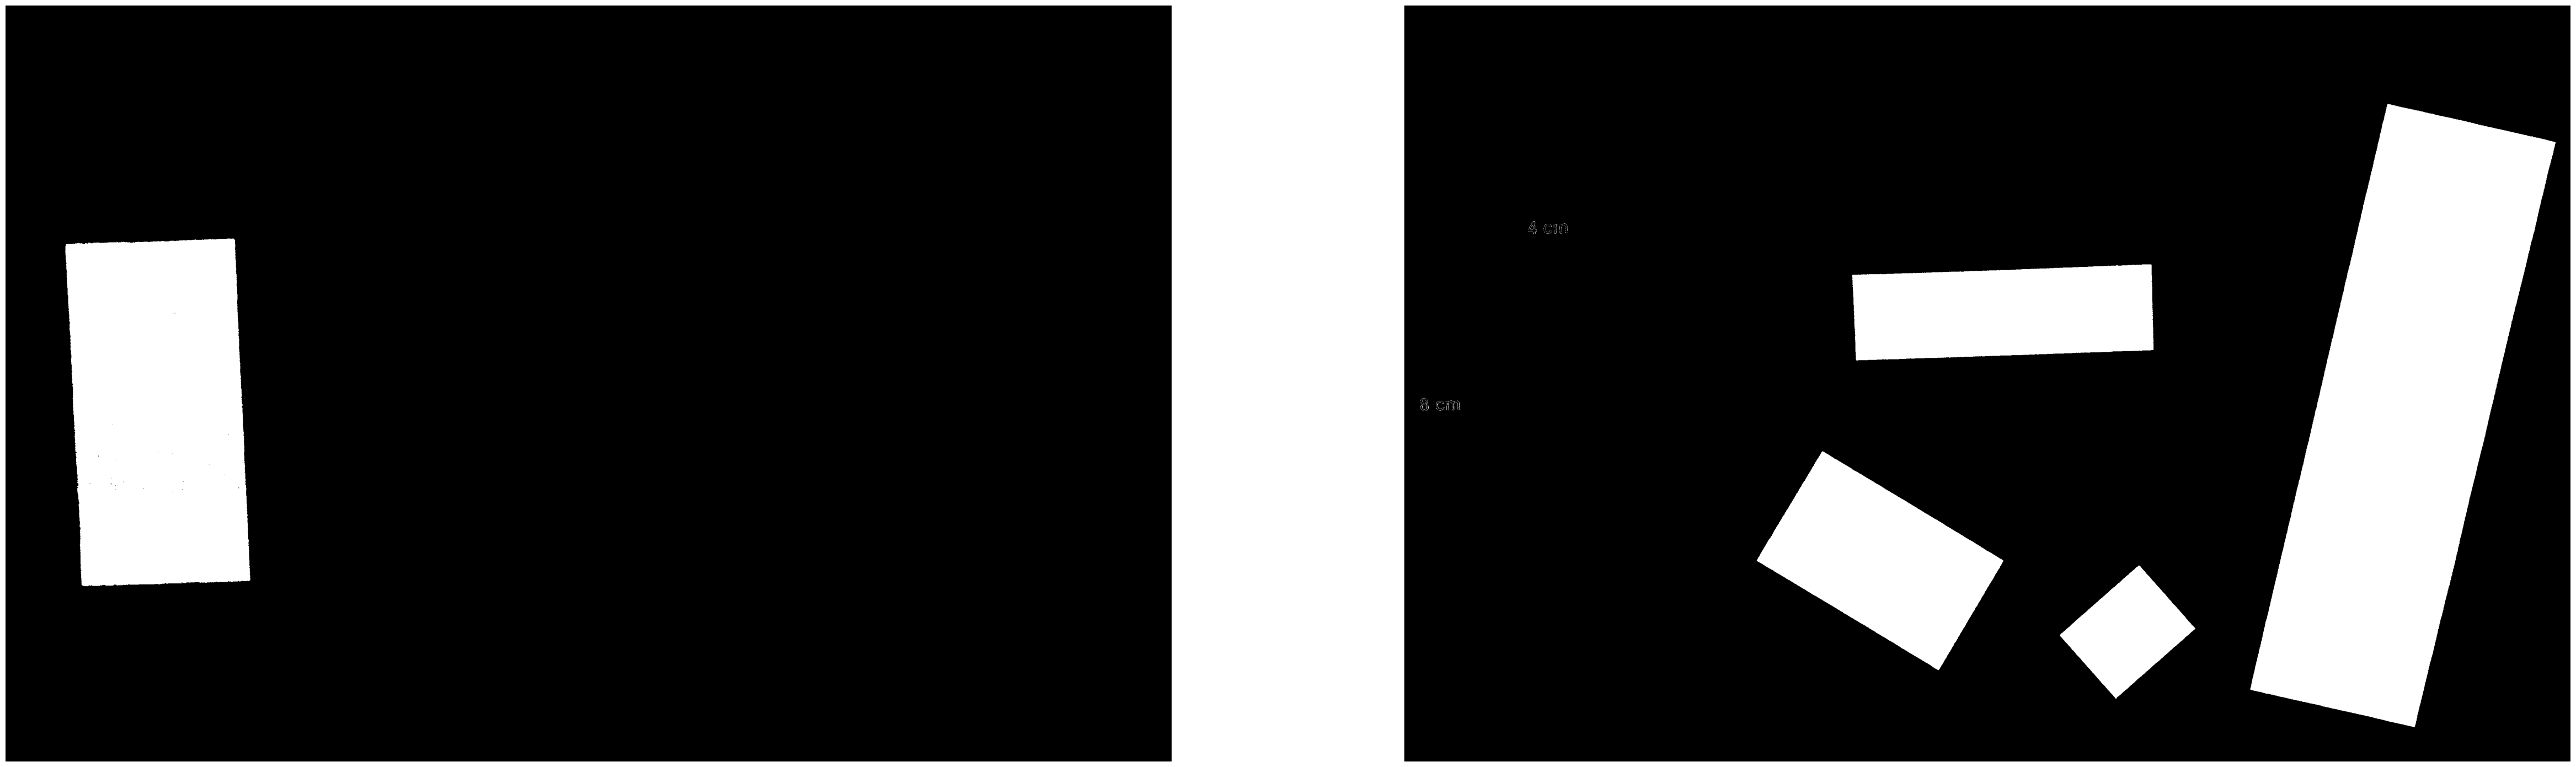

In [ ]:
# Rectangles segmentation
rect_orange = segmentation_two_thresholds(img, (0, 70, 150), (50, 230, 255)) ### Thresholds for segmentation in RGB
rect_green = segmentation_two_thresholds(img, (0, 70, 0), (100, 255, 100)) ### Thresholds for segmentation in RGB
rect_mask = cv2.add(rect_orange, rect_green)

# Finding a reference rectangle based on the size of the contour
drawn_ref, _, ref_cnt = find_contours(rect_mask, 400000, 600000)

# Finding contours of all rectangles
contours_drawn, contours_count, contours = find_contours(rect_mask, 1000, np.inf)

Display mask of all rectangles and mask of reference rectangle.

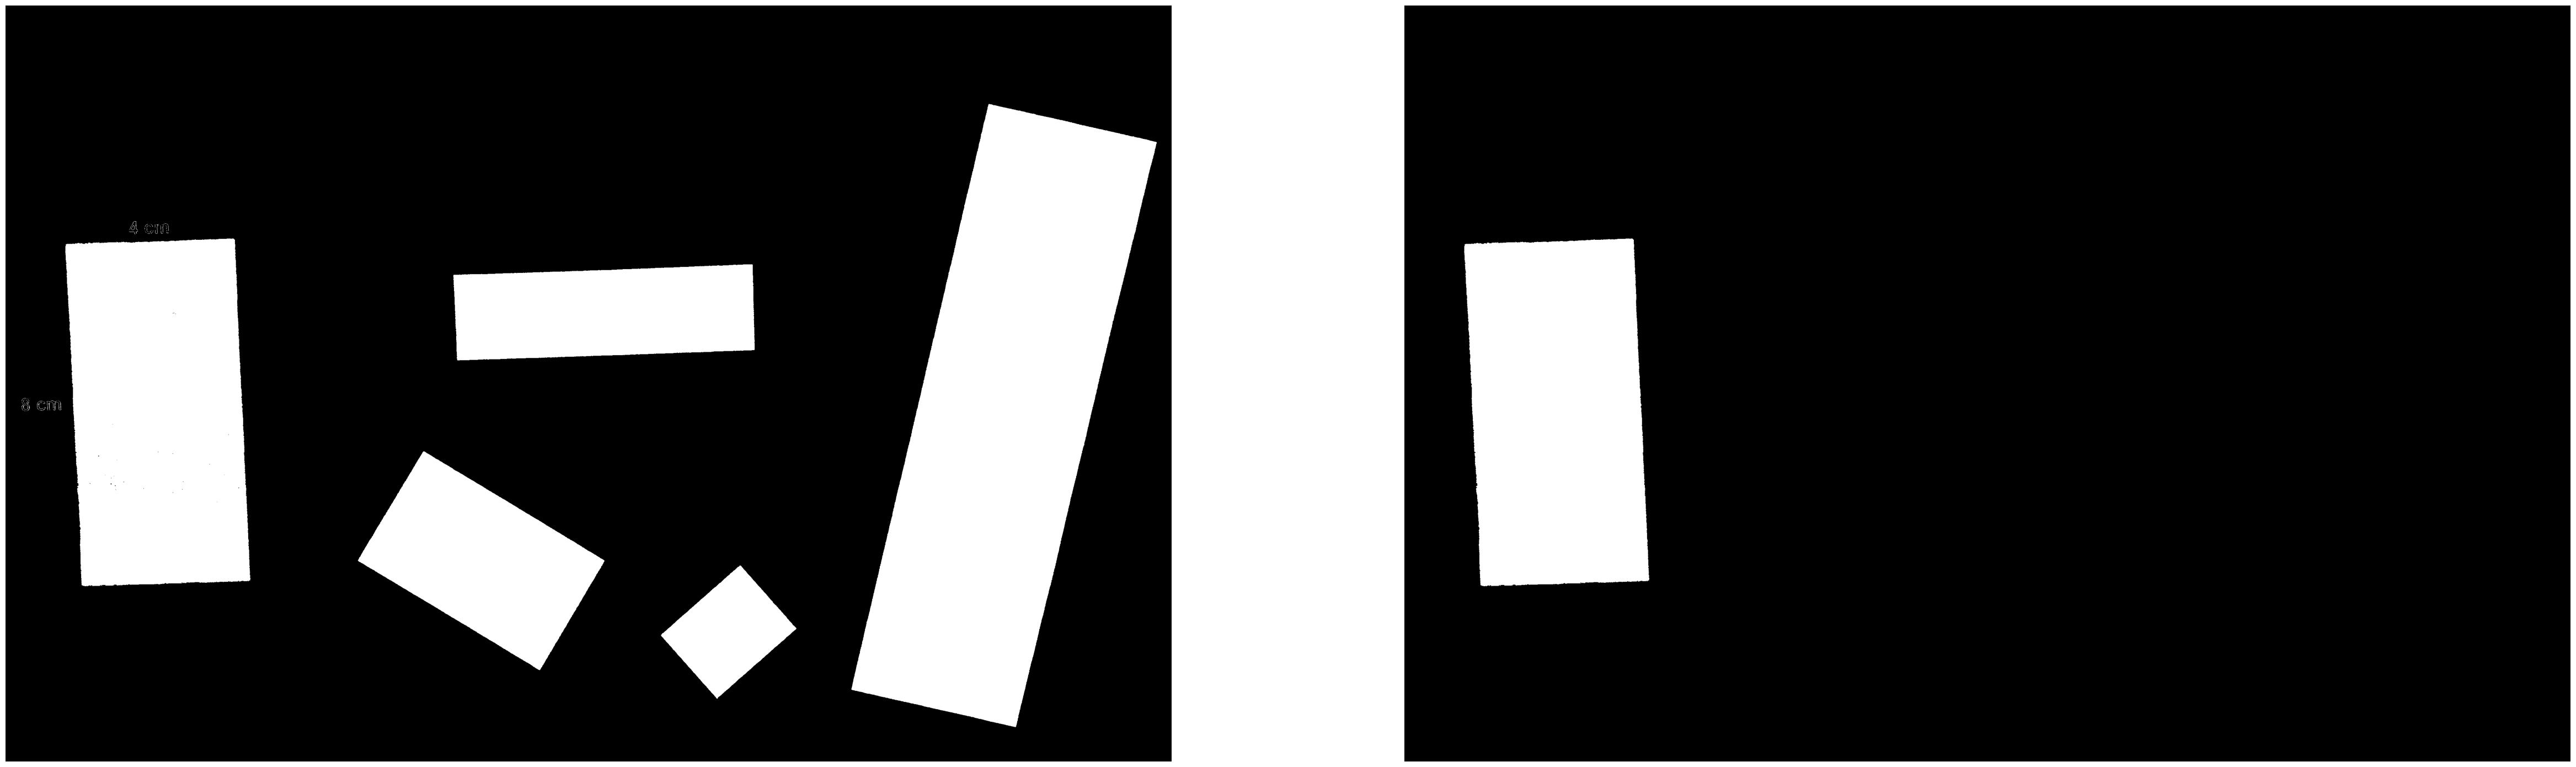

In [ ]:
# Display for verification
plot_images(rect_mask, drawn_ref)

Calculating the ratio of real-world centimeters to pixels.

In [ ]:
# Calculation of the ratio mm/pix
ref_width_real = 4
ref_height_real = 8

rect = cv2.minAreaRect(ref_cnt[0])
ref_width_image, ref_height_image = rect[1]
real_image_ratio = min(ref_width_real, ref_height_real) / min(ref_width_image, ref_height_image)
print(f'Ratio between real width and image width: {real_image_ratio}')

Ratio between real width and image width: 0.007405890630219415


### Main part

In [ ]:
import itertools
import math
import cv2

In [ ]:
print(f"Number of contours - {len(contours)}")

Number of contours - 5


In [ ]:
indices = [i for i in range(len(contours))]
print(f"List of indices - {indices}")

List of indices - [0, 1, 2, 3, 4]


In [ ]:
combinations = list(itertools.combinations(indices, 2))
print(f"All combinations - {combinations}")

All combinations - [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


Now it's finally getting a bit interesting. It remains to **iterate through all possible combinations of contours, approximate them with rectangles,
calculate the distance between all rectangles, and visualize the results appropriately in real units.**

To simplify the entire task, **there is no need to consider any complex special cases** - we do not have to consider shapes overlapping in any way. We assume that the distance is always > 0. This also implies later details such as **not solving cases of a point lying on a line, intersecting lines, etc.**

Let's start with the first building block of our algorithm, the function that **calculates the distance between a point and a line segment in pixels**. This function is the core of our entire solution, so it is necessary to verify that it returns correct values.

I found the inspiration to implement this function on the website: [distance between line segment and point](https://www.geeksforgeeks.org/minimum-distance-from-a-point-to-the-line-segment-using-vectors/). I implemented it completely on my own, without using the proposed code.

This function calculates the perpendicular distance between a line segment defined by two points (**l_pt1** and **l_pt2**) and a third point (**dst_pt**). It checks whether the projection of **dst_pt** onto the line segment falls within the segment or not, and computes the distance accordingly.

In [ ]:
def line_segment_to_point_dist(l_pt1, l_pt2, dst_pt): 
    vector_pt1_pt2 = np.array([l_pt2[0] - l_pt1[0], l_pt2[1] - l_pt1[1]])
    vector_pt1_dst = np.array([dst_pt[0] - l_pt1[0], dst_pt[1] - l_pt1[1]])
    vector_pt2_dst = np.array([dst_pt[0] - l_pt2[0], dst_pt[1] - l_pt2[1]])
    dot_product_pt1_pt2_pt2_dst = np.dot(vector_pt1_pt2, vector_pt2_dst)
    dot_product_pt1_pt2_pt1_dst = np.dot(vector_pt1_pt2, vector_pt1_dst)

    # Closest point is beyond l_pt2
    if dot_product_pt1_pt2_pt2_dst > 0:
        return np.linalg.norm(vector_pt2_dst)
    
    # Closest point is before l_pt1
    if dot_product_pt1_pt2_pt1_dst < 0:
        return np.linalg.norm(vector_pt1_dst)
    
    # Calculate the perpendicular distance - closest point is on line segment
    return np.abs(vector_pt1_pt2[0] * vector_pt1_dst[1] - vector_pt1_pt2[1] * vector_pt1_dst[0]) / np.linalg.norm(vector_pt1_pt2)

Let's test that if function returns correct results.

In [ ]:
assert line_segment_to_point_dist((1,3), (3,4), (4,4)) == 1
assert line_segment_to_point_dist((1,1), (3,1), (2,3)) == 2
assert np.isclose(line_segment_to_point_dist((0,1), (2,3), (-1,4)), 2*np.sqrt(2))
assert line_segment_to_point_dist((0,0), (14,27), (0,-5)) == 5

Passed all asserts.

Now we need another building block, which is the shortest distance between two line segments. For this, we will use the already implemented `line_segment_to_point_dist()` function. Search for the minimum distance between one of the line segments and one of the vertices of another line segment, considering all possible combinations (a total of `4 different combinations`). Then, determine the smallest distance between the two line segments.

In [ ]:
def line_segments_dist(l1_pt1, l1_pt2, l2_pt1, l2_pt2):
    return np.min([line_segment_to_point_dist(l1_pt1, l1_pt2, l2_pt1), 
                  line_segment_to_point_dist(l1_pt1, l1_pt2, l2_pt2), 
                  line_segment_to_point_dist(l2_pt1, l2_pt2, l1_pt1),
                  line_segment_to_point_dist(l2_pt1, l2_pt2, l1_pt2)])

Let's test that if function returns correct results.

In [ ]:
assert line_segments_dist((1,3), (3,4), (5,7), (5,1)) ==  2
assert line_segments_dist((1,5),(6,5), (7,7), (7,5)) == 1
assert np.isclose(line_segments_dist((0,1), (2,3), (-1,4), (1,7)), 2*np.sqrt(2))
assert np.isclose(line_segments_dist((0,1), (2,3), (-1,4), (2,7)), 2*np.sqrt(2))
assert line_segments_dist((0,0),(2,0), (0,1), (2,1)) == 1

Passed all asserts.

Now that we can calculate the shortest distance between two line segments, we have everything we need to compute the shortest distance between two rectangles. Just bear in mind that a rectangle is composed of four connected line segments. Search for the minimum distance between two rectangles by considering each rectangle's four sides and finding the distance between corresponding sides. This involves evaluating all possible combinations of lines (a total of `16 different combinations`) formed by taking one line from each rectangle and determining the smallest distance among them.

In [ ]:
def rect_dist(r1_pts, r2_pts):
    r1 = np.array(r1_pts)
    r2 = np.array(r2_pts)
    l1 = np.array([[r1[i], r1[i+1]] for i in range(len(r1) - 1)] + [[r1[0], r1[-1]]])
    l2 = np.array([[r2[i], r2[i+1]] for i in range(len(r2) - 1)] + [[r2[0], r2[-1]]])
    return np.min([line_segments_dist(pt1[0], pt1[1], pt2[0], pt2[1]) for pt1 in l1 for pt2 in l2])

Let's test that if function returns correct results.

In [ ]:
assert rect_dist(((1,5), (6,5), (6,3), (1,3)), ((7,7), (9,7), (9, 5), (7, 5))) == 1
assert rect_dist(((1,5), (6,5), (6,3), (1,3)), ((4,10), (6, 8), (4, 6), (2,8))) == 1
assert rect_dist(((0,10), (0,8), (3,8), (3,10)), ((2,7), (0,5), (2,3), (4,5))) == 1
assert np.isclose(rect_dist(((6,3), (6,2), (7,2), (7,3)), ((4,5), (6.5,9.5), (5.5,10.5), (3,6))), 2*np.sqrt(2))

Passed all asserts.

We are approaching the final stage. Let's calculate the distances between all rectangles in the frame, and display the distances in a suitable format in centimeters.

Let's convert the list of contours of all rectangles into a suitable format for us, namely into a list of ordered vertices of these rectangles using the functions: **cv2.minAreaRect()**, **cv2.boxPoints()** and  **order_points()**.

In [ ]:
vertices_list = []
for contour in contours:
    rect = cv2.minAreaRect(contour)
    vertices_list.append(order_points(cv2.boxPoints(rect)))
vertices_list

[array([[     2256.5,      2201.3],
        [     2509.9,      1978.1],
        [     2331.1,      1775.3],
        [     2077.8,      1998.5]], dtype=float32),
 array([[     1115.7,      1762.2],
        [     1694.7,      2111.1],
        [     1904.7,      1762.6],
        [     1325.6,      1413.7]], dtype=float32),
 array([[     1430.1,      1128.9],
        [     2379.6,      1095.5],
        [     2369.9,      821.85],
        [     1420.4,      855.29]], dtype=float32),
 array([[     237.25,      1851.1],
        [     776.81,      1826.7],
        [     727.43,      732.51],
        [     187.87,      756.86]], dtype=float32),
 array([[       2680,      2171.3],
        [     3214.1,      2297.1],
        [       3653,      434.01],
        [       3119,       308.2]], dtype=float32)]

Now, using a simple for loop iterating over all possible combinations of pairs of rectangles in the combination, we will call the **rect_dist()** function, convert the result to centimeters using the **real_image_ratio** calculated earlier, and write out the distance.

In [ ]:
for comb in combinations:
    res_px = rect_dist(vertices_list[comb[0]].tolist(), vertices_list[comb[1]].tolist())
    res_cm = res_px * real_image_ratio
    print(f"{comb[0]}<->{comb[1]}: {res_cm:.3f}")

0<->1: 2.000
0<->2: 5.019
0<->3: 9.718
0<->4: 1.555
1<->2: 2.247
1<->3: 2.529
1<->4: 6.283
2<->3: 5.066
2<->4: 3.993
3<->4: 14.324


Let's create a suitable visualization of distances between objects: draw the shortest line segment between rectangles and display its length in centimeters.

To visualize the distances between rectangles, we will need to slightly modify our previous functions: **line_segment_to_point_dist()**, **line_segments_dist_points()** and **rect_dist()**. The main difference is that now we will not only return the shortest distance from each function but also the points that actually create this line segment. In fact, some new calculations will only be added to the **line_segment_to_point_dist()** function, in all other cases, it's about passing the necessary points, i.e., those points returned by the **line_segment_to_point_dist()** function. In the first two cases of this function, it is obvious which points need to be returned — they flow from the logic of calculating the shortest distance (see above). New calculations appear only in the third case. There, we need to find the projection of the point onto the segment (we know for sure that the projection belongs to the segment), for this, we will use the formula P1 + P1_P2 * Dot(P1_DST, P1_P2) / Dot(P1_P2, P1_P2) - [source](https://ru.stackoverflow.com/questions/933182/%D0%92%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B8%D1%82%D1%8C-%D0%BA%D0%BE%D0%BE%D1%80%D0%B4%D0%B8%D0%BD%D0%B0%D1%82%D1%8B-%D0%BE%D1%80%D1%82%D0%BE%D0%B3%D0%BE%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B9-%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%86%D0%B8%D0%B8-%D1%82%D0%BE%D1%87%D0%BA%D0%B8-%D0%BD%D0%B0-%D0%BE%D1%82%D1%80%D0%B5%D0%B7%D0%BE%D0%BA). That's the whole logic.

In [ ]:
def line_segment_to_point_dist_points(l_pt1, l_pt2, dst_pt): 
    vector_pt1_pt2 = np.array([l_pt2[0] - l_pt1[0], l_pt2[1] - l_pt1[1]])
    vector_pt1_dst = np.array([dst_pt[0] - l_pt1[0], dst_pt[1] - l_pt1[1]])
    vector_pt2_dst = np.array([dst_pt[0] - l_pt2[0], dst_pt[1] - l_pt2[1]])
    dot_product_pt1_pt2_pt2_dst = np.dot(vector_pt1_pt2, vector_pt2_dst)
    dot_product_pt1_pt2_pt1_dst = np.dot(vector_pt1_pt2, vector_pt1_dst)

    if dot_product_pt1_pt2_pt2_dst > 0:
        return np.linalg.norm(vector_pt2_dst), l_pt2, dst_pt
    if dot_product_pt1_pt2_pt1_dst < 0:
        return np.linalg.norm(vector_pt1_dst), l_pt1, dst_pt
    
    dist = np.abs(vector_pt1_pt2[0] * vector_pt1_dst[1] - vector_pt1_pt2[1] * vector_pt1_dst[0]) / np.linalg.norm(vector_pt1_pt2)
    point_on_segment_line = np.array(l_pt1) + dot_product_pt1_pt2_pt1_dst / np.dot(vector_pt1_pt2, vector_pt1_pt2) * vector_pt1_pt2
    return dist, (point_on_segment_line[0], point_on_segment_line[1]), dst_pt

In [ ]:
def line_segments_dist_points(l1_pt1, l1_pt2, l2_pt1, l2_pt2):
    min_dist = np.inf
    min_points = None
    point_segment_combs = [(l1_pt1, l1_pt2, l2_pt1), (l1_pt1, l1_pt2, l2_pt2), (l2_pt1, l2_pt2, l1_pt1), (l2_pt1, l2_pt2, l1_pt2)]
    
    for point_segment_comb in point_segment_combs:
        dist, points1, points2 = line_segment_to_point_dist_points(*point_segment_comb) 
        if dist < min_dist:
            min_dist = dist
            min_points = (points1, points2)

    return min_dist, min_points[0], min_points[1]    

In [ ]:
def rect_dist_points(r1_pts, r2_pts):
    r1 = np.array(r1_pts)
    r2 = np.array(r2_pts)
    l1 = np.array([[r1[i], r1[i+1]] for i in range(len(r1) - 1)] + [[r1[0], r1[-1]]])
    l2 = np.array([[r2[i], r2[i+1]] for i in range(len(r2) - 1)] + [[r2[0], r2[-1]]])
    
    min_dist = np.inf
    min_points = None
    for pt1 in l1:
        for pt2 in l2:
            dist, points1, points2 = line_segments_dist_points(pt1[0], pt1[1], pt2[0], pt2[1])
            if dist < min_dist:
                min_dist = dist
                min_points = (points1, points2)
    
    return min_dist, min_points[0], min_points[1]

Now we have all the necessary points that create the shortest distance between each pair of rectangles and these distances in pixels. We just need to visualize them using the conversion of measurements from pixels to centimeters and the functions **cv2.circle()**, **cv2.line()**, and **cv2.putText()**.

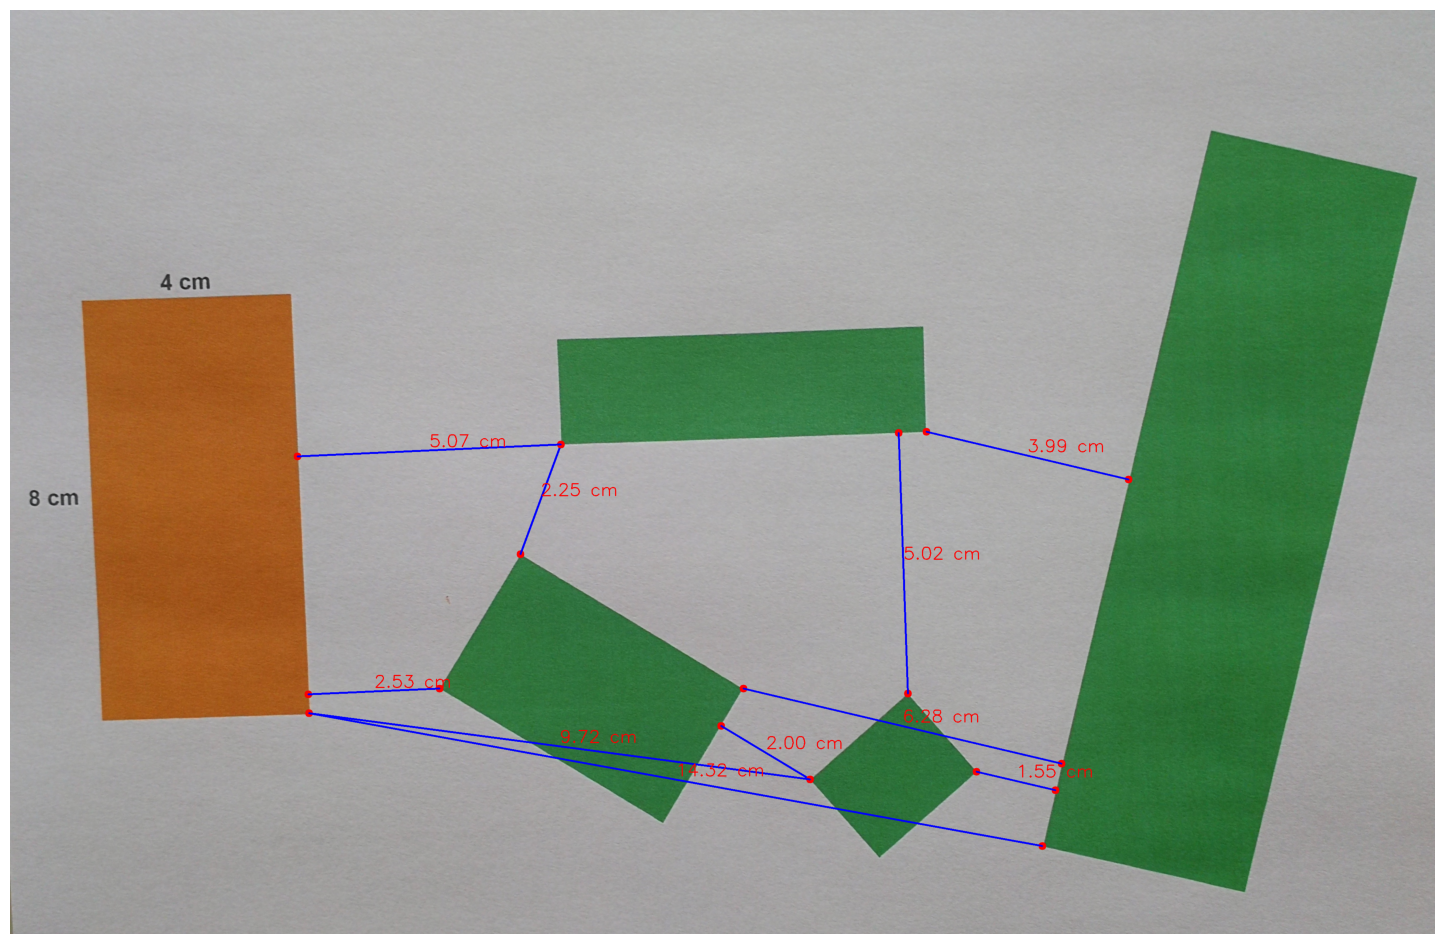

In [ ]:
dist_drawn = img.copy()

for comb in combinations:
    res_px, pt1, pt2 = rect_dist_points(vertices_list[comb[0]].tolist(), vertices_list[comb[1]].tolist())
    res_cm = res_px * real_image_ratio

    cv2.circle(dist_drawn,(int(pt1[0]),int(pt1[1])), 10, (0,0,255), -1)
    cv2.circle(dist_drawn,(int(pt2[0]),int(pt2[1])), 10, (0,0,255), -1)

    cv2.line(dist_drawn, (int(pt1[0]),int(pt1[1])), (int(pt2[0]),int(pt2[1])), color=(255, 0, 0), thickness=3)
    cv2.putText(dist_drawn, "{:.2f} cm".format(res_cm), (int(abs((pt2[0] - pt1[0])/2 + pt1[0])), int(abs((pt2[1] - pt1[1])/2 + pt1[1]) - 10)), 0, 1.5, (0, 0, 255), 2)

plot_images(dist_drawn)

That's all!